# Libraries

In [5]:
# Install packages
import gym
import copy
import torch
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import math
import torchvision.transforms as T
import numpy as np
import matplotlib.patches as mpatches
import time
import torch.nn as nn

from tqdm import tqdm
#from library.MancalaEnv import library.MancalaEnv
from MancalaEnv import MancalaEnv
from game import Game
from randomagent import AgentRandom
from exactagent import AgentExact
from maxagent import AgentMax


# Functions and Classes

In [6]:
def q_learning(env, model, episodes=1000, gamma=0.9, 
               epsilon=0.3, eps_decay=0.99,
               replay=False, replay_size=20, 
               double=False, 
               n_update=10, soft=False):
    '''
    This function implements q-learning with & w/o replay

    Parameters:
    env: The environment to run the training
    model: THe Neural network used for training
    episodes: Number of episodes to train on
    gamma: discount factor
    epsilon: The starting point for epsilon used in e-greedy action selection
    eps_decay: The factor used to exponentially decay epsilon over episodes
    replay: Whether experience replay is used or not
    replay_size: Size of experiences sampled from replay
    n_update: Number of episodes b/w updates


    Returns:
    wins: An array indicating whether the DQN agent won or lost (1/0)
    for each episode of 'episodes'
    '''

    final = []
    memory = []
    rewards = []
    episode_rewards = []
    episode_i=0
    sum_total_replay_time=0
    wins = []

    for episode in tqdm(range(episodes)):
        episode_i+=1
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()
        
        # Reset state
        state = env.reset()
        done = False
        total = 0
        rewards = []
        while not done:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = env.sample(1)
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            next_state, reward, done, win = env.step(action, 1)
            rewards.append(sum(rewards))
            
            # Update memory
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()
             
            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                episode_rewards.append(reward)
                if win:
                    wins.append(1)
                else:
                    wins.append(0)
                break

            if replay:
                # Update network weights using replay memory
                model.replay(memory, replay_size, gamma)
            else: 
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)

            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)

        
    return wins

In [7]:
class DQN(nn.Module):
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
        super(DQN, self).__init__()
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(state_dim, hidden_dim),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim, hidden_dim*2),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim*2, action_dim)
                )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)



    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        '''
        Compute Q values for all actions using the DQN.
        '''
        with torch.no_grad():
            return self.model(torch.Tensor(state))

In [8]:
class DQN_replay(nn.Module):
    '''
    This function builds on the DQN class to include the use 
    of a replay memory, where transitions are stored, and randomly
    sampled when the network is updated
    '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
        super(DQN_replay, self).__init__()
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(state_dim, hidden_dim),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim, hidden_dim*2),
                        torch.nn.LeakyReLU(),
                        torch.nn.Linear(hidden_dim*2, action_dim)
                )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)



    def update(self, state, y):
        '''
        Update the weights of the network given a training sample.
        '''
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, state):
        '''
        Compute Q values for all actions using the DQN.
        '''
        with torch.no_grad():
            return self.model(torch.Tensor(state))

    def _move(self, game):
        state = game.board()
        with torch.no_grad():
            action = self.model(torch.Tensor(state))
        action = torch.argmax(q_values).item()
        return(action)

    def replay(self, memory, size, gamma=0.9):
        """New replay function"""
        #Try to improve replay speed
        if len(memory)>=size:
            batch = random.sample(memory,size)
            batch_t = list(map(list, zip(*batch))) #Transpose batch list
            states = batch_t[0]
            actions = batch_t[1]
            next_states = batch_t[2]
            rewards = batch_t[3]
            is_dones = batch_t[4]
        
            states = torch.Tensor(states)
            actions_tensor = torch.Tensor(actions)
            next_states = torch.Tensor(next_states)
            rewards = torch.Tensor(rewards)
            is_dones_tensor = torch.Tensor(is_dones)
        
            is_dones_indices = torch.where(is_dones_tensor==True)[0]
        
            all_q_values = self.model(states) # predicted q_values of all states
            all_q_values_next = self.model(next_states)
            #Update q values
            all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
            all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
        
            
            self.update(states.tolist(), all_q_values.tolist())

In [9]:
# Number of states
n_state = 14
# Number of actions
n_action = 6
# Number of episodes
episodes = 2
# Number of hidden nodes in the DQN
n_hidden = 64
# Learning rate
lr = 0.001

# Training
## Regular DQN Experiments
### Different Reward Structures of DQN on Random Opponent

In [10]:
# Get DQN results
env1 = MancalaEnv(reward_type = "sparse_reward", opponent = 1)
env2 = MancalaEnv(reward_type = "keep_ahead_reward", opponent = 1)
env3 = MancalaEnv(reward_type = "dont_fall_behind_reward", opponent = 1)

test_envs = [env1, env2, env3]
DQN_experiment_1 = []
for env in test_envs:
    simple_dqn = DQN(n_state, n_action, n_hidden, lr)
    DQN_wins = q_learning(env, simple_dqn, episodes, gamma=.9, epsilon=0.2, replay=False)
    DQN_experiment_1.append(DQN_wins)

100%|██████████| 2/2 [00:00<00:00,  3.15it/s]


### Different Reward Structures of DQN on Exact Opponent (experiment 2)

In [11]:
# Get DQN results
env1 = MancalaEnv(reward_type = "sparse_reward", opponent = 2)
env2 = MancalaEnv(reward_type = "keep_ahead_reward", opponent = 2)
env3 = MancalaEnv(reward_type = "dont_fall_behind_reward", opponent = 2)

test_envs = [env1, env2, env3]
DQN_experiment_2 = []
for env in test_envs:
    simple_dqn = DQN(n_state, n_action, n_hidden, lr)
    DQN_wins = q_learning(env, simple_dqn, episodes, gamma=.9, epsilon=0.2, replay=False)
    DQN_experiment_2.append(DQN_wins)

100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


### Different Reward of DQN on Max Opponent (experiment 3)

In [12]:
# Get DQN results
env1 = MancalaEnv(reward_type = "sparse_reward", opponent = 3)
env2 = MancalaEnv(reward_type = "keep_ahead_reward", opponent = 3)
env3 = MancalaEnv(reward_type = "dont_fall_behind_reward", opponent = 3)

test_envs = [env1, env2, env3]
DQN_experiment_3 = []
for env in test_envs:
    simple_dqn = DQN(n_state, n_action, n_hidden, lr)
    DQN_wins = q_learning(env, simple_dqn, episodes, gamma=.9, epsilon=0.2, replay=False)
    DQN_experiment_3.append(DQN_wins)

100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


## Plot Results
### Functions and Parameters

In [13]:
labels = ["Sparse Reward","Keep Ahead Reward","Falling Behind Reward"]
colors = ["darkcyan", "goldenrod", "darkblue"]

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid')/w

def create_plot(results, title, labs, cols):
    '''
    Given a set of results,
    Create a line plot grouped by each member of result
    '''
    for idx, trial in enumerate(results):
        trial = np.array(trial)
        plt.plot(moving_average(trial,1000), label = labs[idx], color = cols[idx])
    plt.legend()
    plt.xlabel("Episodes")
    plt.ylabel("Average Wins")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()
    plt.close()



### Create Plots

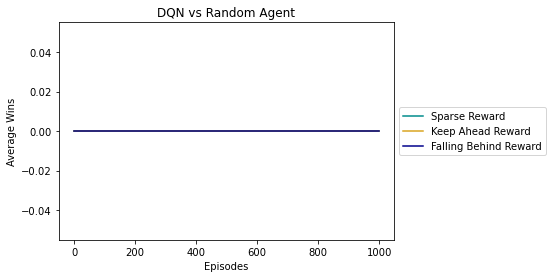

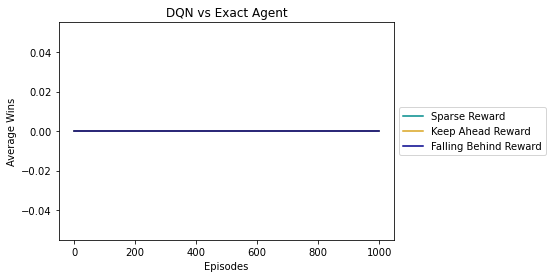

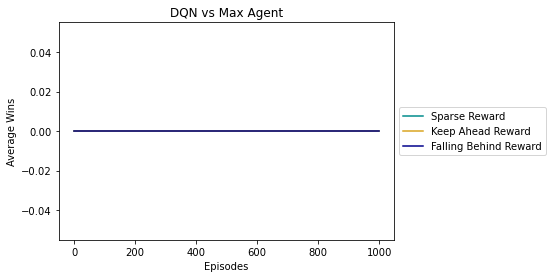

In [14]:
create_plot(DQN_experiment_1, "DQN vs Random Agent", labels, colors)
create_plot(DQN_experiment_2, "DQN vs Exact Agent", labels, colors)
create_plot(DQN_experiment_3, "DQN vs Max Agent", labels, colors)

## Replay DQN Experiments
### Replay DQN vs Random agent (Experiment 1)

In [15]:
# Create Environments
env1 = MancalaEnv(reward_type = "sparse_reward", opponent = 1)
env2 = MancalaEnv(reward_type = "keep_ahead_reward", opponent = 1)
env3 = MancalaEnv(reward_type = "dont_fall_behind_reward", opponent = 1)

# Get replay results
test_envs = [env1, env2, env3]
Replay_DQN_experiment_1 = []
for env in test_envs:
    dqn_replay = DQN_replay(n_state, n_action, n_hidden, lr)
    DQN_replay_wins = q_learning(env, dqn_replay, episodes, gamma=.9, epsilon=0.2, replay=True)
    Replay_DQN_experiment_1.append(DQN_replay_wins)

 50%|█████     | 1/2 [00:00<00:00,  5.03it/s]<ipython-input-8-73c63da7e624>:69: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
100%|██████████| 2/2 [00:00<00:00, 10.00it/s]


### Replay DQN vs Exact Agent (experiment 2)

In [16]:
# Create Agents
env1 = MancalaEnv(reward_type = "sparse_reward", opponent = 2)
env2 = MancalaEnv(reward_type = "keep_ahead_reward", opponent = 2)
env3 = MancalaEnv(reward_type = "dont_fall_behind_reward", opponent = 2)

# Get replay results
test_envs = [env1, env2, env3]
Replay_DQN_experiment_2 = []
for env in test_envs:
    dqn_replay = DQN_replay(n_state, n_action, n_hidden, lr)
    DQN_replay_wins = q_learning(env, dqn_replay, episodes, gamma=.9, epsilon=0.2, replay=True)
    Replay_DQN_experiment_2.append(DQN_replay_wins)

 50%|█████     | 1/2 [00:00<00:00,  1.99it/s]<ipython-input-8-73c63da7e624>:69: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


### Replay DQN vs Max Agent (experiment 3)

In [17]:
env1 = MancalaEnv(reward_type = "sparse_reward", opponent = 3)
env2 = MancalaEnv(reward_type = "keep_ahead_reward", opponent = 3)
env3 = MancalaEnv(reward_type = "dont_fall_behind_reward", opponent = 3)

# Get replay results
test_envs = [env1, env2, env3]
Replay_DQN_experiment_3 = []
for env in test_envs:
    dqn_replay = DQN_replay(n_state, n_action, n_hidden, lr)
    DQN_replay_wins = q_learning(env, dqn_replay, episodes, gamma=.9, epsilon=0.2, replay=True)
    Replay_DQN_experiment_3.append(DQN_replay_wins)

 50%|█████     | 1/2 [00:00<00:00,  6.02it/s]<ipython-input-8-73c63da7e624>:69: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
100%|██████████| 2/2 [00:00<00:00,  7.03it/s]


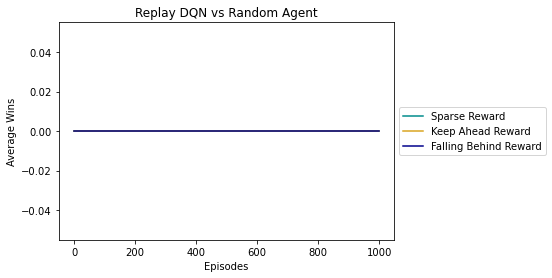

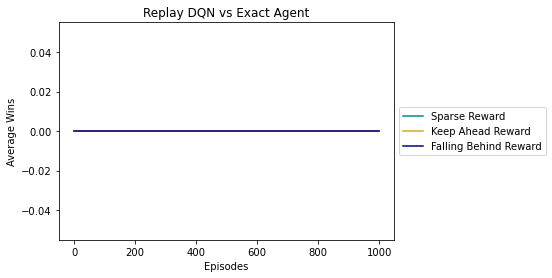

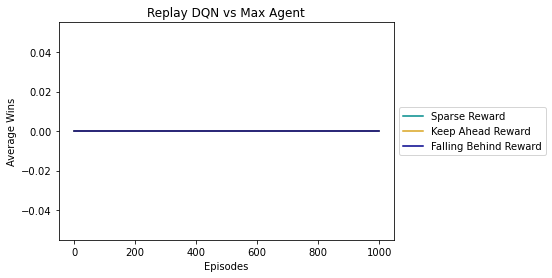

In [18]:
create_plot(Replay_DQN_experiment_1, "Replay DQN vs Random Agent", labels, colors)
create_plot(Replay_DQN_experiment_2, "Replay DQN vs Exact Agent", labels, colors)
create_plot(Replay_DQN_experiment_3, "Replay DQN vs Max Agent", labels, colors)

# Final DQN Trainig

In [20]:
# Create Agent
final_replay_dqn = DQN_replay(n_state, n_action, n_hidden, lr)
env1 = MancalaEnv(reward_type = "dont_fall_behind_reward", opponent = 2)
env2 = MancalaEnv(reward_type = "dont_fall_behind_reward", opponent = 3)
env3 = MancalaEnv(reward_type = "dont_fall_behind_reward", opponent = 1)

test_envs = [env3, env1, env2]
final_replay_dqn_results = []
episodes = 10
for env in test_envs:
    final_replay_dqn_wins = q_learning(env, final_replay_dqn, episodes, gamma=.9, epsilon=0.2, replay=True)
    final_replay_dqn_results.append(final_replay_dqn_wins)

 10%|█         | 1/10 [00:00<00:01,  7.44it/s]<ipython-input-8-73c63da7e624>:69: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
100%|██████████| 10/10 [00:01<00:00,  9.43it/s]


### Create Plots

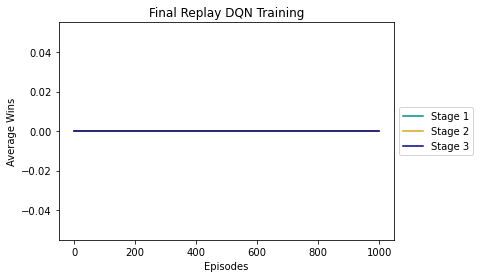

In [21]:
# Create Plot of Training:
labels2 = ["Stage 1","Stage 2","Stage 3", "Stage 4"]
colors2 = ["darkcyan", "goldenrod", "darkblue", "red"]
create_plot(Replay_DQN_experiment_3, "Final Replay DQN Training", labels2, colors2)

## Save Final Replay DQN

In [75]:
PATH = "Replay_dqn_state_dict.pt"
torch.save(final_replay_dqn.model.state_dict(), PATH)